In [75]:
from ultralytics import YOLO
import cv2 as cv
from PIL import Image
from torchvision import models
import torch
from torchvision import transforms
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

In [12]:
label_path = "/home/khanh/data/LPT/VisDrone/VisDrone2019-MOT-val/annotations/uav0000137_00458_v.txt"

In [39]:
frame_path = "/home/khanh/data/LPT/VisDrone/VisDrone2019-MOT-val/sequences/uav0000137_00458_v"
frame_names = os.listdir(frame_path)
frame_names.sort()

In [21]:
def load_annotations_to_dict(txt_file):
    annotations = {}

    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 6:
                continue  # Skip malformed lines

            frame_id = int(parts[0])
            target_id = int(parts[1])
            bbox_left = float(parts[2])
            bbox_top = float(parts[3])
            bbox_width = float(parts[4])
            bbox_height = float(parts[5])

            # Convert bbox to [left, upper, right, lower]
            left = bbox_left
            upper = bbox_top
            right = bbox_left + bbox_width
            lower = bbox_top + bbox_height

            bbox_entry = [left, upper, right, lower, target_id]

            if frame_id not in annotations:
                annotations[frame_id] = []
            annotations[frame_id].append(bbox_entry)

    return annotations

In [37]:
labels = load_annotations_to_dict(label_path)

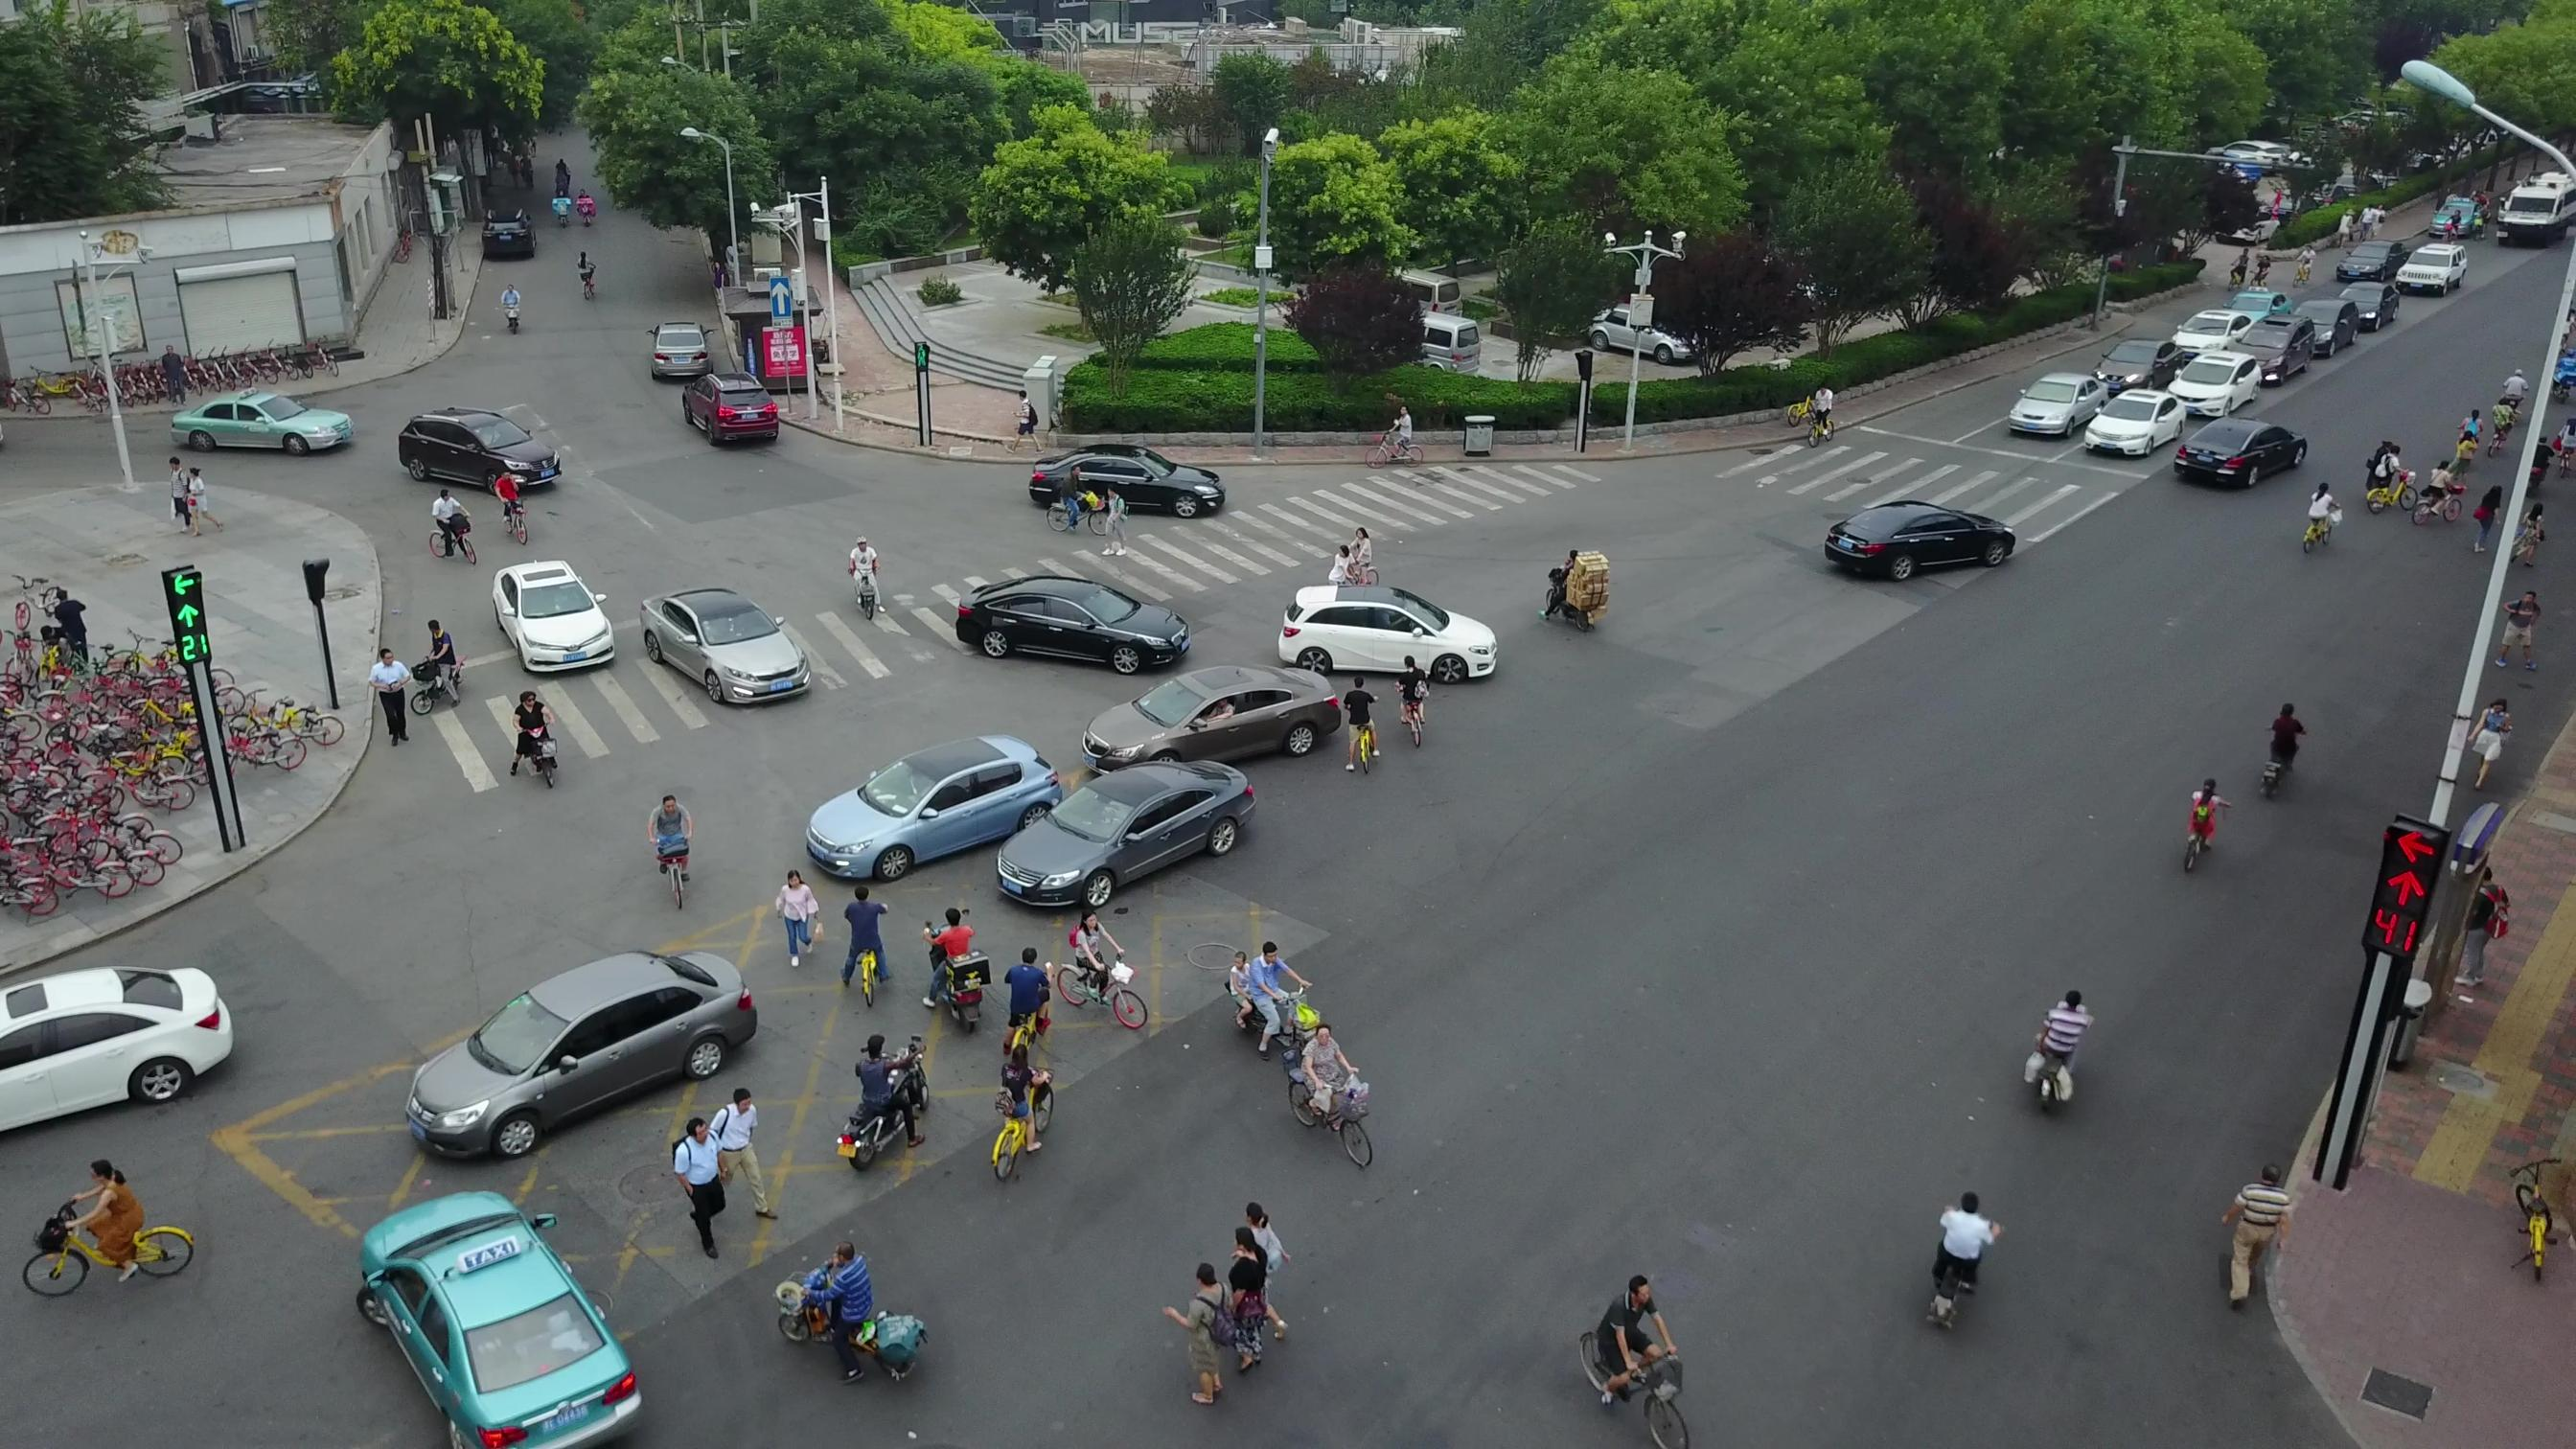

In [20]:
img = Image.open(frame_path[0]).convert('RGB')
img

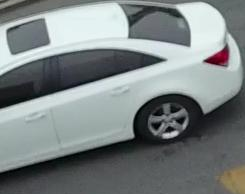

In [28]:
img.crop(data[1][0][:4])

In [64]:
def cosine_similarity(vec1, vec2):
    vec1 = torch.tensor(vec1, dtype=torch.float32)
    vec2 = torch.tensor(vec2, dtype=torch.float32)

    # Compute dot product and norms
    dot_product = torch.dot(vec1, vec2)
    norm_vec1 = torch.norm(vec1)
    norm_vec2 = torch.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        return torch.tensor(0.0)

    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

In [73]:
def track_objects_between_frames(frame1_objects, frame2_objects):
    """
    Track objects between two frames using ResNet embeddings and cosine similarity.
    
    Args:
        frame1_objects: List of M cropped object bounding boxes from frame 1 (PIL Images)
        frame2_objects: List of N cropped object bounding boxes from frame 2 (PIL Images)
        
    Returns:
        similarity_matrix: MxN matrix with cosine similarity scores
    """
    # 1. Load ResNet model
    resnet = models.resnet50(pretrained=True)
    # Remove the final classification layer
    resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
    resnet.eval()
    
    # 2. Define image transformations (same as ResNet training)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # 3. Extract embeddings for frame 1 objects
    frame1_embeddings = []
    for obj in frame1_objects:
        # Apply transformations
        img_tensor = transform(obj).unsqueeze(0)
        
        # Get embedding
        with torch.no_grad():
            embedding = resnet(img_tensor)
            
        # Flatten the embedding
        embedding = embedding.squeeze().flatten()
        frame1_embeddings.append(embedding)
    
    # 4. Extract embeddings for frame 2 objects
    frame2_embeddings = []
    for obj in frame2_objects:
        # Apply transformations
        img_tensor = transform(obj).unsqueeze(0)
        
        # Get embedding
        with torch.no_grad():
            embedding = resnet(img_tensor)
            
        # Flatten the embedding
        embedding = embedding.squeeze().flatten()
        frame2_embeddings.append(embedding)
    
    # 5. Compute cosine similarity between all pairs of objects
    M = len(frame1_objects)
    N = len(frame2_objects)
    similarity_matrix = torch.zeros((M, N))
    
    for i in range(M):
        for j in range(N):
            similarity_matrix[i, j] = cosine_similarity(
                frame1_embeddings[i].unsqueeze(0),
                frame2_embeddings[j].unsqueeze(0)
            )
    
    return similarity_matrix, frame1_objects, frame2_objects

def visualize_similarity_matrix_improved(similarity_matrix, frame1_objects, frame2_objects):
    """
    Visualize the similarity matrix with improved layout matching the example.
    
    Args:
        similarity_matrix: MxN torch tensor with cosine similarity scores
        frame1_objects: List of frame 1 objects (PIL Images)
        frame2_objects: List of frame 2 objects (PIL Images)
    """
    M = len(frame1_objects)
    N = len(frame2_objects)
    
    # Convert similarity matrix to numpy for visualization
    sim_matrix_np = similarity_matrix.numpy()
    
    # Create figure with appropriate size
    fig = plt.figure(figsize=(14, 12))
    
    # Create the main layout
    # We'll have a left column for frame 1 objects, a top row for frame 2 objects,
    # and the main similarity matrix
    
    # For left column width and top row height (adjust as needed)
    left_col_width = 0.15  
    top_row_height = 0.15
    
    # Main similarity matrix
    ax_sim = plt.axes([left_col_width, 0.15, 0.72, 0.7])
    im = ax_sim.imshow(sim_matrix_np, cmap='viridis', vmin=0, vmax=1)
    ax_sim.set_xticks(range(N))
    ax_sim.set_yticks(range(M))
    ax_sim.set_xticklabels([f"{j}" for j in range(N)])
    ax_sim.set_yticklabels([f"{i}" for i in range(M)])
    ax_sim.set_xlabel('Frame 2 Objects')
    ax_sim.set_ylabel('Frame 1 Objects')
    
    # Add colorbar
    cbar_ax = plt.axes([0.88, 0.15, 0.03, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Cosine Similarity')
    
    # Set the title
    ax_title = plt.axes([0, 0.9, 0.15, 0.1])
    ax_title.text(0.5, 0.5, 'Similarity Matrix', ha='center', va='center', fontsize=12, fontweight='bold')
    ax_title.axis('off')
    
    # Add frame 2 objects on the top
    thumbnail_width = 0.72 / N
    for j in range(N):
        ax = plt.axes([left_col_width + j * thumbnail_width, 0.9, thumbnail_width, 0.05])
        ax.imshow(frame2_objects[j])
        ax.set_title(f'Obj {j+1}')
        ax.axis('off')
    
    # Add frame 1 objects on the left
    thumbnail_height = 0.7 / M
    for i in range(M):
        ax = plt.axes([0.05, 0.85 - (i+1) * thumbnail_height, 0.08, thumbnail_height])
        ax.imshow(frame1_objects[i])
        ax.set_title(f'Obj {i+1}', x=-0.1, y=0.5, rotation=0, ha='right', va='center')
        ax.axis('off')
    
    # Find the best matches (highest similarity for each frame 1 object)
    best_matches = np.argmax(sim_matrix_np, axis=1)
    
    # Create the match text box
    match_text = "Best matches:\n"
    for i in range(M):
        match_j = best_matches[i]
        match_text += f"Frame 1 Obj {i+1} → Frame 2 Obj {match_j+1} (sim: {sim_matrix_np[i, match_j]:.2f})\n"
    
    # Add text box for matches
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax_matches = plt.axes([0.1, 0.02, 0.8, 0.12])
    ax_matches.text(0.5, 0.5, match_text, ha='center', va='center', bbox=props, transform=ax_matches.transAxes)
    ax_matches.axis('off')
    
    plt.savefig('similarity_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Function to handle tracking with visualization
def track_and_visualize(frame1_objects, frame2_objects):
    """
    Main function to track objects and visualize the results.
    
    Args:
        frame1_objects: List of cropped object bounding boxes from frame 1 (PIL Images)
        frame2_objects: List of cropped object bounding boxes from frame 2 (PIL Images)
    """
    # Track objects between frames
    print("Computing similarity matrix...")
    similarity_matrix, f1_objs, f2_objs = track_objects_between_frames(frame1_objects, frame2_objects)
    
    # Visualize the results with improved layout
    print("Generating visualization...")
    visualize_similarity_matrix_improved(similarity_matrix, f1_objs, f2_objs)
    
    # Return for further processing if needed
    return similarity_matrix

In [76]:
# Crop object
instance_imgs_frames = []
for frame_id in range(1, 3):
    frame = Image.open(os.path.join(frame_path, frame_names[frame_id-1])).convert('RGB')
    frame_obj = []
    for b in labels[frame_id]:
        frame_obj.append(frame.crop(b[:4]))
    instance_imgs_frames.append(frame_obj) 
    
# for frame_id, (img_path, bbox) in enumerate(zip(image_path, frames_bboxes)):
#     frame_obj = []
#     frame = Image.open(img_path).convert('RGB')
#     for b in bbox:
#         frame_obj.append(frame.crop(b))
    

Computing similarity matrix...


/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generating visualization...


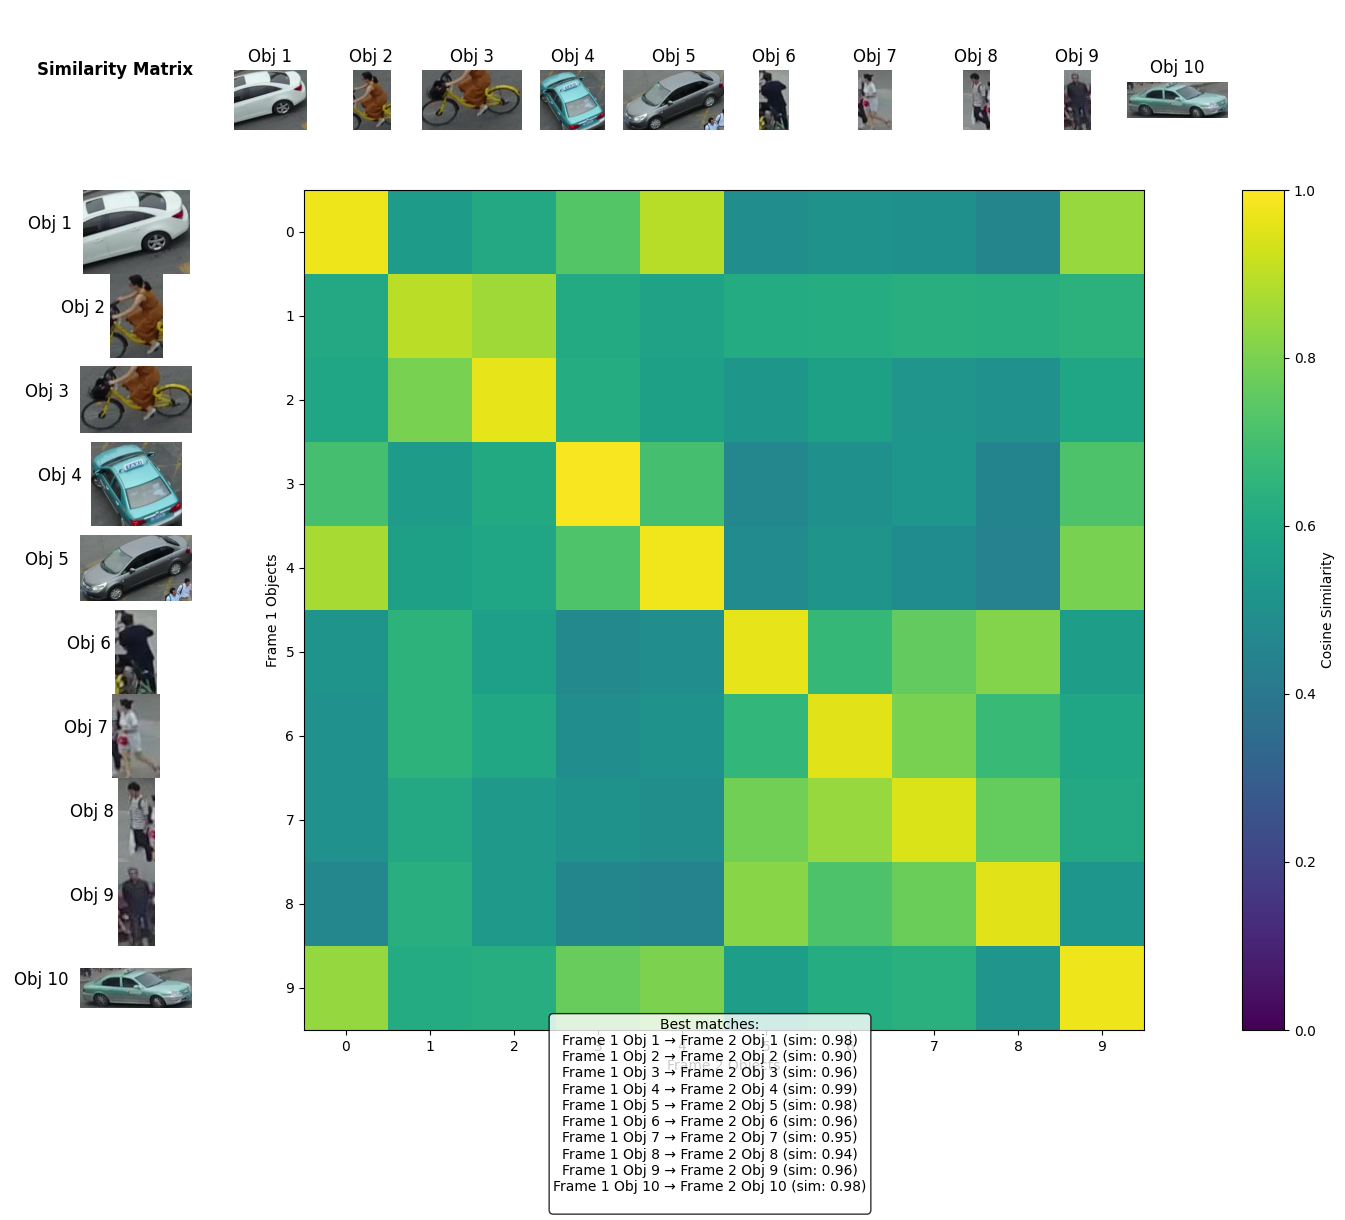

In [77]:
similarity_matrix = track_and_visualize(instance_imgs_frames[0], instance_imgs_frames[1])

# Test Build graph

In [100]:
import os, time
import cv2, random
import pickle, joblib
import sklearn.metrics
import numpy as np
np.set_printoptions(suppress=True)
import gurobipy as gp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

from lib.tracking import Tracker
from lib.utils import getIoU, computeBoxFeatures, interpolateTrack, interpolateTracks

In [78]:
seq = 'MOT17-01'
detector = 'DPM'

In [80]:
det_file = './result/{}/det_{}.txt'.format(seq, detector)
app_file = './result/{}/app_det_{}.npy'.format(seq, detector)
dets = np.loadtxt(det_file, delimiter=',')
app_feats = np.load(app_file)
assert dets.shape[0] == app_feats.shape[0], 'Shape mismatch'

In [90]:
dets[:10]

array([[          1,          -1,         770,         460,          40,         127,           1,          -1,          -1,          -1],
       [          1,          -1,         465,         467,          46,         106,        0.97,          -1,          -1,          -1],
       [          1,          -1,        1224,         455,          56,         173,           1,          -1,          -1,          -1],
       [          1,          -1,         718,         456,          43,         132,           1,          -1,          -1,          -1],
       [          1,          -1,         995,         455,          69,         191,           1,          -1,          -1,          -1],
       [          1,          -1,         671,         460,          28,          87,        0.84,          -1,          -1,          -1],
       [          2,          -1,         465,         467,          47,         110,        0.99,          -1,          -1,          -1],
       [          2,       

In [98]:
start_frame = 0
end_frame = 15
app_thresh = 0.75

In [88]:
curr_ind = np.logical_and(dets[:, 0] >= start_frame, dets[:, 0] <= end_frame)
curr_dets = np.concatenate([dets[curr_ind, 0][:, None], dets[curr_ind, 2:7],
                            np.arange(dets[curr_ind].shape[0])[:, None]], axis=1)

curr_dets[:, 3:5] = curr_dets[:, 3:5] + curr_dets[:, 1:3] # convert to frame,x1,y1,x2,y2,conf,node_ind
curr_app_feats = app_feats[curr_ind]
curr_app_feats = curr_app_feats / np.linalg.norm(curr_app_feats, axis=1, keepdims=True)

In [94]:
curr_app_feats.shape

(104, 512)

In [96]:
def get_trans_probs(curr_dets, curr_app_feats, app_thresh, max_frame_gap = 5):
    """
    Inputs: tracker: an instance of the Tracker.
            curr_dets: frame, x1, y1, x2, y2, det_confidence, node_ind.
            curr_app_feats: normalized appearance features for curr_dets.
            max_frame_gap: frame gap used to connect detections.
    Return: transition probabilities for LP that handles false negatives(missing detections).
    """
    edge_ind = 0
    edge_feats, lifted_probs = [], []
    edge_type = [] #1:base edge 2:lifted edge-1:pruned lifted edge
    
    cos_sim_mat = np.dot(curr_app_feats, curr_app_feats.T)
    linkIndexGraph = np.zeros((curr_dets.shape[0], curr_dets.shape[0]), dtype=np.int32)
    for i in range(curr_dets.shape[0]):
        for j in range(curr_dets.shape[0]):
            frame_gap = curr_dets[j][0] - curr_dets[i][0]
            cos_sim = cos_sim_mat[i, j]

            if frame_gap == 1: #base edge
                edge_type.append(1)
                feats = computeBoxFeatures(curr_dets[i, 1:5], curr_dets[j, 1:5])
                iou = getIoU(curr_dets[i, 1:5], curr_dets[j, 1:5])
                feats.extend((iou, cos_sim))
                edge_feats.append(feats)
                edge_ind += 1
                linkIndexGraph[i, j] = edge_ind

            elif frame_gap > 1 and frame_gap <= max_frame_gap: #lifted edge
                if cos_sim > app_thresh:
                    edge_type.append(2)
                    time_weight = 0.9 ** frame_gap
                    lifted_probs.append(cos_sim * time_weight)
                else:
                    edge_type.append(-1)

                edge_ind += 1
                linkIndexGraph[i, j] = edge_ind
    return linkIndexGraph

In [102]:
linkIndexGraph = get_trans_probs(curr_dets, curr_app_feats, app_thresh, max_frame_gap = 5)

In [103]:
linkIndexGraph

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)